# Discussion 01

**Brent Allen Thorne**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Taylor Series

### Provided Code

In [2]:
import TaylorPlot

In [3]:
help(TaylorPlot)

Help on module TaylorPlot:

NAME
    TaylorPlot - Created on Fri Oct 11 19:35:32 2024

DESCRIPTION
    @author: MMH_user

FUNCTIONS
    PlotTaylorSeries(my_fun: str = 'cos(x)', n_order: int = 5, x_eval: float = 0)

FILE
    /home/plastic/Documents/MSSE/chem277B/hw/EX_01/TaylorPlot.py




In [4]:
import inspect

print(inspect.getsource(TaylorPlot))

# -*- coding: utf-8 -*-
"""
Created on Fri Oct 11 19:35:32 2024

@author: MMH_user
"""
import math
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, sympify, diff

# usage:
#    PlotTaylorSeries(n_order = 10, my_fun = 'sin(x)', x_eval = 0)


def PlotTaylorSeries(my_fun: str = "cos(x)", n_order: int = 5, x_eval: float = 0):

    n_order += 1

    expr = sympify(my_fun)  # for example "cos(x)"
    x = symbols("x")

    # plotting the actual function
    x_plot = np.arange(x_eval - 7, x_eval + 7, 1 / 1000)
    y_plot = np.array([float(expr.subs({x: xx})) for xx in x_plot])

    plt.plot(x_plot, y_plot, "k-", linewidth=3, alpha=0.5)

    # zeroth order
    y_eval = float(expr.subs({x: x_eval}))
    y_plotn = y_eval * np.ones(x_plot.shape)

    # all other orders
    for n in range(n_order - 1):

        fxdx = diff(expr, x)  # performing derivative
        y = float(fxdx.subs({x: x_eval}))  # evaluating derivative at
        # x = x_eval
        expr = fxdx

   

There are a few thinging we might improve it, such as proper docstrings and a parameter to set the plotting domain.  As it is, this code will fail for functions that return complex floats.  Also, the mixture of symbolic calculations together with numberic plotting is rather poor form (and quite slow!).

Much better to use SymPy.lambdify to convert symbolic expressions into fast, vectorized Python functions.

See: Chapter 3, Symbolic Computing, Numerical Evaluation of Robert Johansson's "Numerical Python: Scientific Computing and Data Science Applications with Numpy, SciPy and Matplotlib"

In [5]:
# help(sym.lambdify)

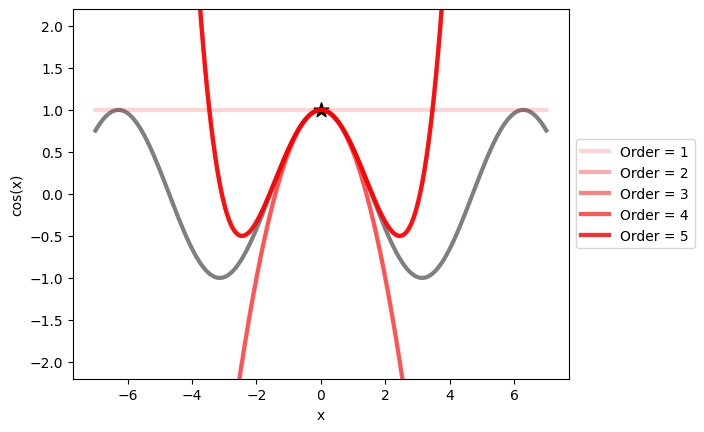

CPU times: user 3.88 s, sys: 70.1 ms, total: 3.95 s
Wall time: 3.95 s


In [6]:
%%time

TaylorPlot.PlotTaylorSeries()

In [7]:
# fix up
import math
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, sympify, diff, lambdify


def FixUpPlotTaylorSeries(my_fun: str = "cos(x)", n_order: int = 5, x_eval: float = 0):

    n_order += 1

    expr = sympify(my_fun)  # for example "cos(x)"
    x = symbols("x")

    # Lambdify the original function
    f_numeric = lambdify(x, expr, modules=["numpy"])

    # Plotting the actual function
    x_plot = np.arange(x_eval - 7, x_eval + 7, 1 / 1000)
    y_plot = f_numeric(x_plot)  # evaluate lambda function

    plt.plot(x_plot, y_plot, "k-", linewidth=3, alpha=0.5)

    # Zeroth order
    y_eval = f_numeric(x_eval)
    y_plotn = y_eval * np.ones_like(x_plot)

    # All other orders
    for n in range(n_order - 1):
        fxdx = diff(expr, x)  # perform derivative
        fxdx_numeric = lambdify(x, fxdx, modules=["numpy"])  # Lambdify the derivative
        y = fxdx_numeric(x_eval)  # evaluate derivative at x_eval, using lambda fucntion
        expr = fxdx  # update expr for next derivative

        y_plotn += (1 / math.factorial(n + 1)) * y * (x_plot - x_eval) ** (n + 1)

        transp = (n + 1) / n_order
        plt.plot(
            x_plot,
            y_plotn,
            "r-",
            linewidth=3,
            alpha=transp,
            label="Order = " + str(n + 1),
        )

    plt.xlabel("x")
    plt.ylim(
        (
            np.min(y_plot) - 1.2 * abs(np.min(y_plot)),
            np.max(y_plot) + 1.2 * abs(np.max(y_plot)),
        )
    )
    plt.ylabel(my_fun)
    plt.legend(
        loc="center left", bbox_to_anchor=(1, 0.5), ncol=int(np.ceil(n_order / 15))
    )
    plt.scatter(x_eval, y_eval, marker="*", s=120, color=[0, 0, 0])
    plt.tight_layout()
    plt.show()

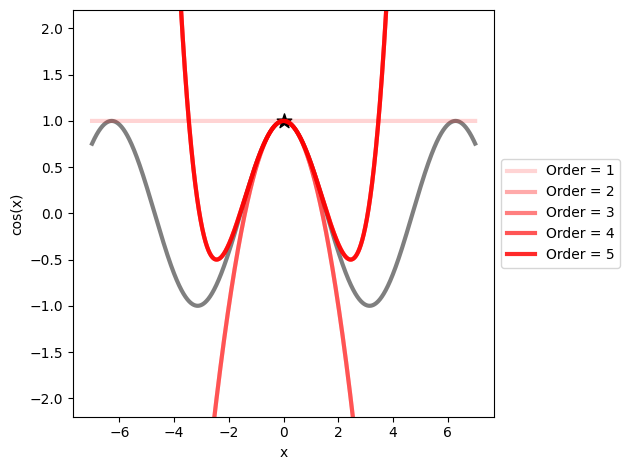

CPU times: user 160 ms, sys: 14 ms, total: 174 ms
Wall time: 173 ms


In [8]:
%%time

FixUpPlotTaylorSeries()

Nice! That's nearly a 30x speed up.  ;-)

In [9]:
import sympy as sym

# TaylorPlot.PlotTaylorSeries(my_fun="sqrt(x+1)") # nope, TypeError: Cannot convert complex to float

### Our Enhanced Symbolic Implementation

Let's leverage our work done fro HW01 and build a more generalized Class.

In [10]:
import sympy as sym


class Limits:
    """
    Represents a numeric domain for plotting or evaluation.

    Attributes:
        lower (float): Lower bound of the domain.
        upper (float): Upper bound of the domain.
    """

    def __init__(self, lower: float, upper: float):
        self.lower = lower
        self.upper = upper

    def __repr__(self):
        return f"<Limits: lower={self.lower}, upper={self.upper}>"


class TaylorSymPlot:
    """
    Generates and plots symbolic Taylor approximations of a function.

    Attributes:
        func (sympy expression): The symbolic function to approximate.
        domain (Limits): The plotting domain for x.
        x0 (float): The expansion point for the Taylor series.
        max_order (int): The highest order of Taylor approximation to compute.
    """

    def __init__(
        self,
        func=sym.cos(sym.Symbol("x")),
        domain=Limits(-2 * sym.pi, 2 * sym.pi),
        x0=0,
        max_order=5,
        y_range=None,
    ):
        self.x = sym.Symbol("x")
        self.f = func
        self.x0 = x0
        self.domain = domain
        self.max_order = max_order
        self.taylor_series = self._compute_taylor_series()
        self.y_range = y_range

    def _compute_taylor_series(self):
        """
        Computes Taylor approximations of the function up to max_order.

        Returns:
            List of sympy expressions representing Taylor polynomials.
        """
        series = []
        for n in range(1, self.max_order + 1):
            taylor = sum(
                (sym.diff(self.f, self.x, k).subs(self.x, self.x0) / sym.factorial(k))
                * (self.x - self.x0) ** k
                for k in range(n + 1)
            )
            series.append(taylor)
        return series

    def plot(self):
        """
        Plots the original function and its Taylor approximations over the specified domain.
        """
        sym.init_printing(use_latex=True)

        # Build plot
        p = sym.plot(
            self.f,
            *self.taylor_series,
            (self.x, self.domain.lower, self.domain.upper),
            show=False,
            legend=True,
            xlabel="x",
            ylabel="f(x)",
            title=f"Function and Taylor Approximations at $x_0$ = {self.x0}",
        )

        # Label original function
        p[0].label = f"$f(x) = {sym.latex(self.f)}$"
        p[0].line_color = "blue"

        # Use a predefined color palette
        colors = ["green", "red", "orange", "purple", "brown"]

        # Label Taylor approximations
        for i in range(len(self.taylor_series)):
            p[i + 1].label = f"{i + 1}th order Taylor"
            # p[i + 1].line_style = ".." # Nope, SymPy backend doesn't line styles.
            # p[i + 1].line_color = None
            p[i + 1].line_color = colors[i % len(colors)]

        if self.y_range is not None:
            p.ylim = (self.y_range.lower, self.y_range.upper)

        p.show()

    def __repr__(self):
        return f"<TaylorSymPlot: f(x)={self.f}, x0={self.x0}, domain={self.domain}>"

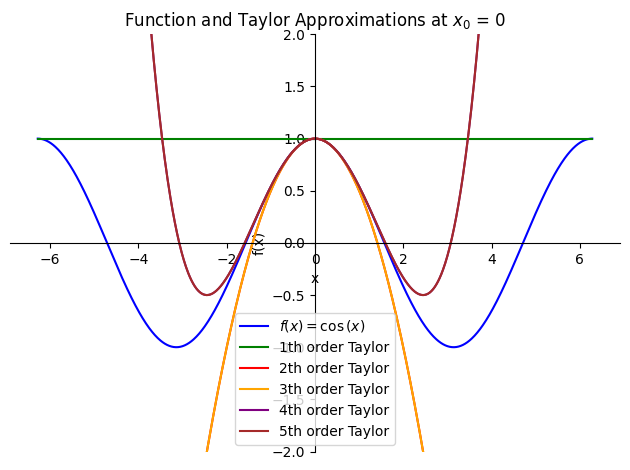

CPU times: user 3.67 s, sys: 21 ms, total: 3.7 s
Wall time: 425 ms


In [11]:
%%time
plotter = TaylorSymPlot(y_range=Limits(-2, 2))  # Use defaults
plotter.plot()

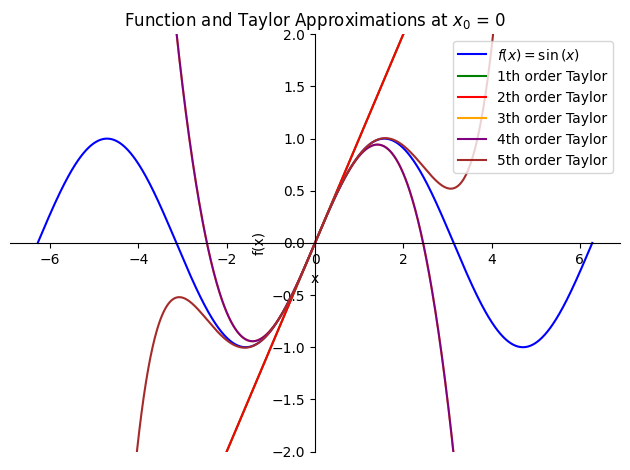

In [12]:
f = sym.sin(sym.Symbol("x"))  # Set a custom function
plotter = TaylorSymPlot(f, y_range=Limits(-2, 2))
plotter.plot()

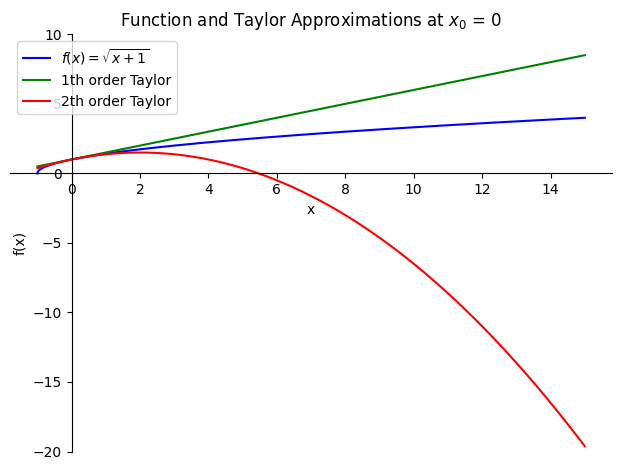

CPU times: user 149 ms, sys: 5.01 ms, total: 154 ms
Wall time: 153 ms


In [13]:
%%time
plotter = TaylorSymPlot(
    sym.sqrt(sym.Symbol("x") + 1),
    domain=Limits(-1, 15),
    y_range=Limits(-20, 10),
    max_order=2,
)
plotter.plot()

### Our Enhanced Numerical Implementation

Now let's adapt our code for numerical calculation.  We'll use sym.lambdify to evaluate our functions within the domain.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym


class Limits:
    """
    Represents a numeric domain for plotting or evaluation.

    Attributes:
        lower (float): Lower bound of the domain.
        upper (float): Upper bound of the domain.
    """

    def __init__(self, lower: float, upper: float):
        self.lower = lower
        self.upper = upper

    def __repr__(self):
        return f"<Limits: lower={self.lower}, upper={self.upper}>"


class TaylorNumPlot:
    """
    Numerically evaluates and plots a function and its Taylor approximations using matplotlib.

    Attributes:
        func (sympy expression): Symbolic function to approximate.
        domain (Limits): Domain over which to evaluate and plot.
        x0 (float): Expansion point for the Taylor series.
        max_order (int): Maximum order of Taylor approximation.
    """

    # def __init__(self, func=sym.sqrt(1 + sym.Symbol("x")), domain=Limits(1e-3, 10), x0=0, max_order=5):
    def __init__(
        self,
        func=sym.cos(sym.Symbol("x")),
        domain=Limits(-2 * sym.pi, 2 * sym.pi),
        x0=0,
        max_order=5,
        y_range=None,
    ):
        self.x = sym.Symbol("x")
        self.func = func
        self.x0 = x0
        self.domain = domain
        self.max_order = max_order
        self.y_range = y_range

        # FIXME!!! Inherit TaylorSymPlot and extend, than rather cut-n-paste as we've done here.
        # This is just a toy but we want to demostrate best practices.

        # Lambdify the true function
        self.f = sym.lambdify(self.x, self.func, modules=["numpy"])

        # Compute Taylor coefficients symbolically
        self.coeffs = [
            sym.diff(self.func, self.x, n).subs(self.x, self.x0) / sym.factorial(n)
            for n in range(max_order + 1)
        ]

        # Build Taylor approximations as lambda functions
        self.taylor_funcs = [
            self._build_taylor_func(order) for order in range(1, max_order + 1)
        ]

        # Domain values
        self.x_vals = np.linspace(
            float(self.domain.lower), float(self.domain.upper), 400
        )

    def _build_taylor_func(self, order):
        """
        Constructs a lambda function for the Taylor polynomial of given order.
        """

        def approx(x):
            return sum(
                float(self.coeffs[n]) * (x - self.x0) ** n for n in range(order + 1)
            )

        return np.vectorize(approx)

    def plot(self, loglog=False):
        """
        Plots the true function and its Taylor approximations.

        Args:
            loglog (bool): Whether to use log-log scale for plotting.
        """
        y_true = self.f(self.x_vals)

        plt.figure(figsize=(10, 6))
        if loglog:
            plt.loglog(
                self.x_vals,
                y_true,
                label=f"$f(x) = {sym.latex(self.func)}$",
                color="blue",
                linewidth=2,
            )
        else:
            plt.plot(
                self.x_vals,
                y_true,
                label=f"$f(x) = {sym.latex(self.func)}$",
                color="blue",
                linewidth=2,
            )

        colors = ["green", "red", "orange", "purple", "brown"]
        linestyles = ["--", ":", "-.", "-", (0, (3, 1, 1, 1))]

        for i, f_approx in enumerate(self.taylor_funcs):
            y_approx = f_approx(self.x_vals)
            label = f"{i + 1}th order Taylor"
            style = linestyles[i % len(linestyles)]
            color = colors[i % len(colors)]
            if loglog:
                plt.loglog(
                    self.x_vals, y_approx, label=label, linestyle=style, color=color
                )
            else:
                plt.plot(
                    self.x_vals, y_approx, label=label, linestyle=style, color=color
                )

        plt.xlabel("x")
        plt.ylabel("f(x)")
        if self.y_range is not None:
            plt.title(f"Function and Taylor Approximations at $x_0 = {self.x0}$")
        else:
            plt.title(
                f"Function and Taylor Approximations at $x_0 = {self.x0}$ (loglog)"
            )
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if self.y_range is not None:
            plt.ylim(
                self.y_range.lower, self.y_range.upper
            )  # It's the little differences that matter.  ;-)
        plt.show()

    def __repr__(self):
        return (
            f"<TaylorNumericPlot: f(x)={self.func}, x0={self.x0}, domain={self.domain}>"
        )

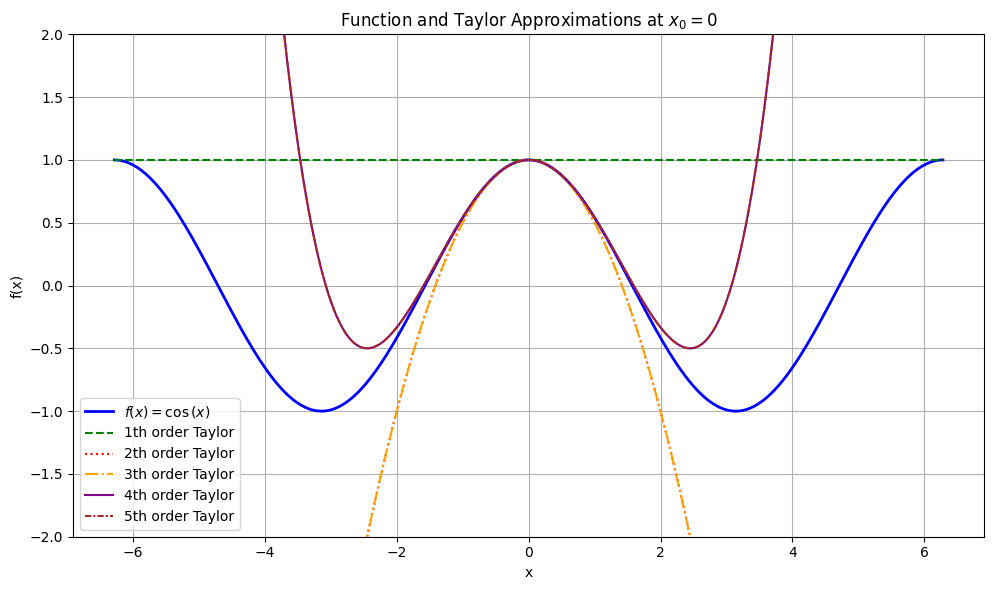

CPU times: user 249 ms, sys: 6 ms, total: 255 ms
Wall time: 254 ms


In [15]:
%%time
plotter = TaylorNumPlot(y_range=Limits(-2, 2))  # Use default function
plotter.plot()

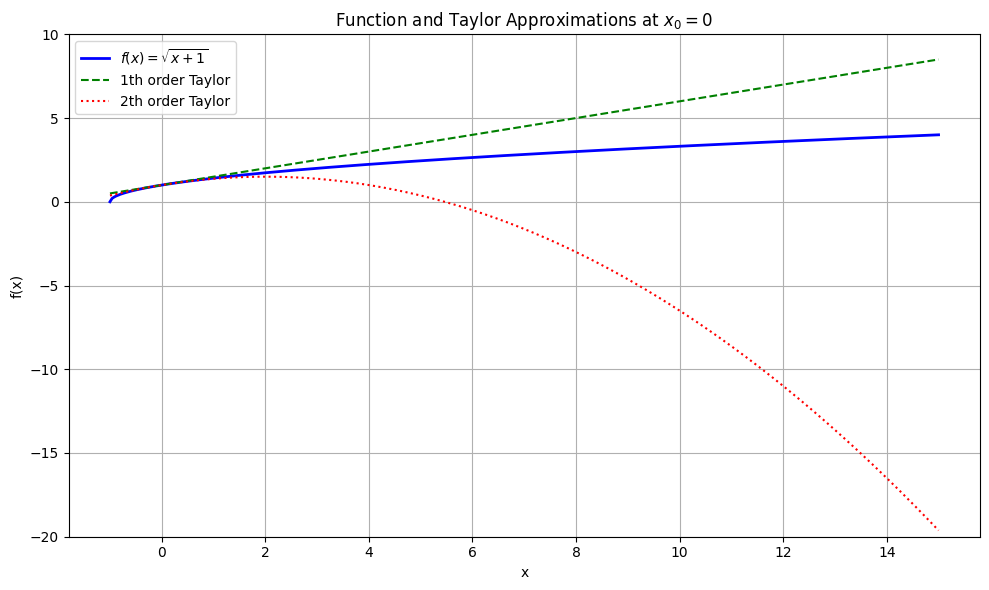

CPU times: user 152 ms, sys: 4.95 ms, total: 157 ms
Wall time: 155 ms


In [16]:
%%time
plotter = TaylorNumPlot(
    sym.sqrt(sym.Symbol("x") + 1),
    domain=Limits(-1, 15),
    y_range=Limits(-20, 10),
    max_order=2,
)
plotter.plot()

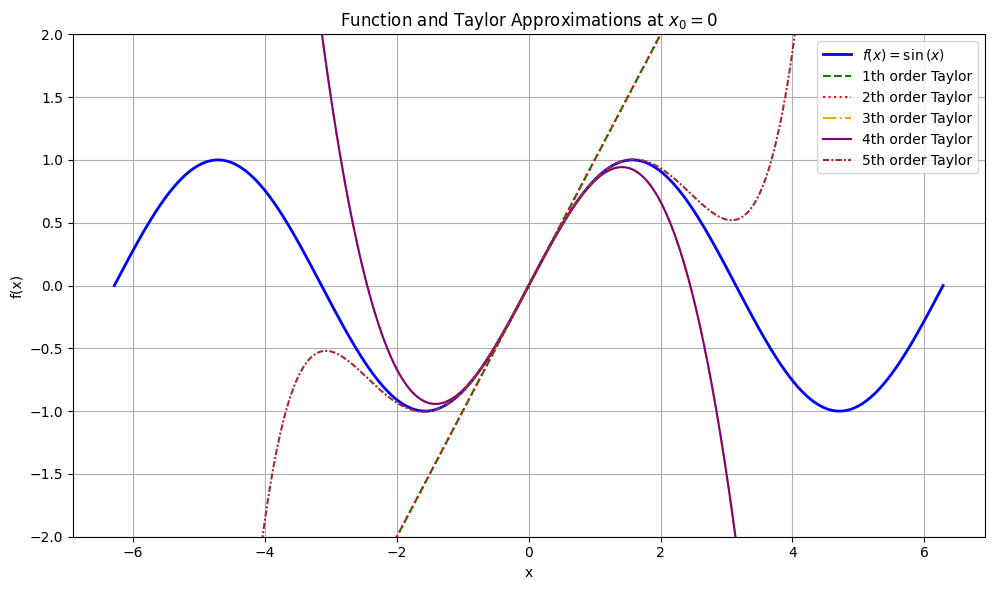

CPU times: user 181 ms, sys: 4.99 ms, total: 186 ms
Wall time: 185 ms


In [17]:
%%time
plotter = TaylorNumPlot(sym.sin(sym.Symbol("x")), max_order=5, y_range=Limits(-2, 2))
plotter.plot()

Nice!  We also have a bit more control over our plot with matplotlib.

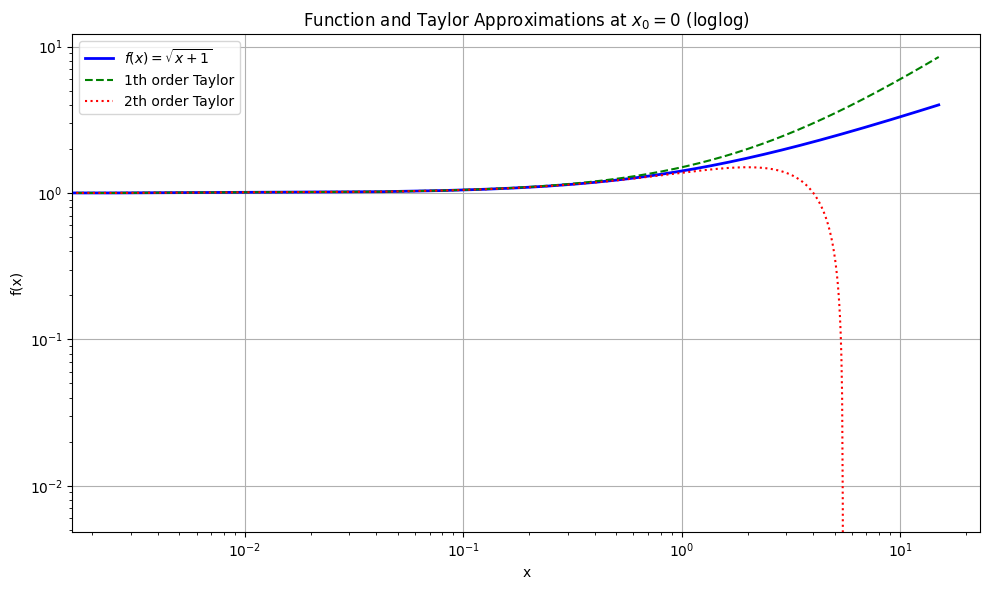

In [18]:
TaylorNumPlot(sym.sqrt(sym.Symbol("x") + 1), domain=Limits(-1, 15), max_order=2).plot(
    loglog=True
)

## Pythonic Classes

### Class Basics


In [19]:
def f1(a, b):
    return a + b

def f2(a, b):
    return a * b

f1(3,5), f2(3,5)

In [20]:
class MyClass():
    def f1(self, a, b):
        self.res = a + b
        return a+b

    def f2(self, a,b):
        return a*b*self.res

In [21]:
C = MyClass()

In [22]:
C.f1(2,3)

In [23]:
dir(C)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'f1',
 'f2',
 'res']

In [24]:
getattr(C, "res"), C.res

In [25]:
getattr(C, "f1")

<bound method MyClass.f1 of <__main__.MyClass object at 0x7f5a9b79dee0>>

In [26]:
C.f2(2, 3)

In [27]:
getattr(C, "res")

In [28]:
my_fun = getattr(C, "f1")
my_fun(3, 4)

What is the purpose of self?

It represents the instance of the class being used.

### Inherentance

In [29]:
class C0:
    def f0(self, a, b):
        res = a * b
        return res

class C1:
    def f1(self, a, b):
        res = a + b
        return res

In [30]:
class C2(C1, C0):
    def f2(self, a, b, c, d):  #  run: C = C2()
        return a + b + c + d

In [31]:
C = C2()
dir(C)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'f0',
 'f1',
 'f2']

In [32]:
C.f0(2, 3)

In [33]:
C.f1(2, 3)

In [34]:
C.f2(2, 3, 4, 5)

### Super 

Calling a method of a parent class from within a method of a child class.

In [35]:
class C2(C1, C0):
    def f2(self, a, b, c, d):
        # res = C1.f1(a,b)       # hum, this seems to work.  why?
        res = super().f1(a, b)  # think about this...
        return res + c + d


#C2.f2(1, 2, 3, 5, 7)  # Works with f2 too!

See also: https://docs.python.org/3/library/functions.html#super

```
class C(B):
    def method(self, arg):
        super().method(arg)    # This does the same thing as:
                               # super(C, self).method(arg)
```

### Dunder Methods `__init__` 

In [36]:
# starter code
import numpy as np

class Encoder:
    def __init__(self):
        NT = "ACGT"
        Code = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
        Dict = {key: value for key, value in zip(NT, Code)}
        self.Enc = lambda Sequence: [Dict[s] for s in Sequence]

    def Encode(self, Sequence):

        print(self.Enc(Sequence))           #   Change this line such that it returns an np.array. Make
        #   sure that the array is correctly oriented!



class Map(Encoder):
    def __init__(self):
        super().__init__()  #        run: M = Map()

    def run(self, S):  #        Out = M.run(['AACCTG', 'TTGTG'])
        return list(map(self.Enc, S))    #  Change this line such that it calls the Encode method
        #  from the Encoder, via super

In [37]:
M = Map()

In [38]:
Out = M.run(["AACCTG", "TTGTG"])

In [39]:
type(Out)

list

In [40]:
E = Encoder()
E.Encode("AACCTG")

[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]


In [41]:
dir(E)

['Enc',
 'Encode',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [45]:
# updated code
import numpy as np

class Encoder:
    def __init__(self):
        NT = "ACGT"
        Code = [[1, 0, 0, 0], 
                [0, 1, 0, 0], 
                [0, 0, 1, 0], 
                [0, 0, 0, 1]]
        Dict = {key: value for key, value in zip(NT, Code)}
        self.Enc = lambda Sequence: [Dict[s] for s in Sequence]

    def Encode(self, Sequence):
        # Return a NumPy array with shape (len(Sequence), 4)
        return np.array(self.Enc(Sequence))


class Map(Encoder):
    def __init__(self):
        super().__init__() 

    def run(self, S):
        #return [self.Encode(seq) for seq in S] # ?
        return [super().Encode(seq) for seq in S]


In [46]:
E = Encoder()
out = E.Encode("AACCTG")

In [47]:
type(out)

numpy.ndarray